## Analysis of 1st day in the RCF study
Checking amygdala activation in the CS+US condition of the task
- masking amygdala
- avergaing activation
- plot

In [7]:
# load libraries
import glob
import pandas as pd
import numpy as np
import nilearn
import nilearn.plotting
import nilearn.input_data
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import cmdstanpy
import arviz as az

In [8]:
## Screening subjects by SCR as Nachshon analyzed - 67% as US:
subject_list = ['029','040','1074','1205','1223','1237','1245','1247',
               '1280','1301','1337','1350','1359','1374','1392','020',
               '1072','1099','1206','1212','1216','1258','1266','1268',
               '1320','1340','1345','1346','1362','1379','1393','1457','1460',
               '1373','1272','1291','1309'] # '1269','1271','1319', '1220','1376',
len(subject_list)

37

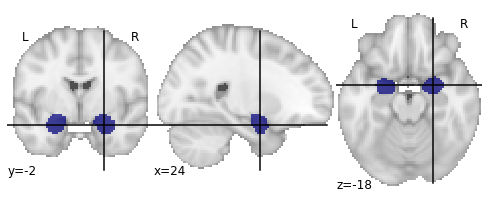

In [9]:
# load mask
mask_file = 'amygdala_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=20", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)

# create a masker 
fwhm = 4
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=fwhm, standardize=False, 
                                        detrend=False, verbose=5)

In [10]:
#us_cond = '/media/Data/work/RCF_FSLNoScrub/Sink_respNOScrub/1stLevel/_subject_id_{sub}/_modelestimate0/results/cope{cope_num}.nii.gz'
us_cond = '/media/Data/work/RCF_FSLNoScrub/Sink_respNOScrub/1stLevel/_subject_id_{sub}/_modelestimate0/results/zstat{cope_num}.nii.gz'
cope_num =  4#taking shock vs. noshock


In [12]:
us = []
timeseriesAmg = []
counter = 1 # set counter to give percentage of progress
for sub in subject_list:
   # try:
    func = us_cond.format(sub=sub, cope_num= cope_num)
    print(func)
    sub = func.split('id_')[1].split('/')[0]
    print(sub)
    print(f'\nFinished {counter/len(subject_list)*100}% of subjects')
    counter = counter +1 
    # amygdala
    tArr = masker.fit_transform(func)
    meanT = np.mean(tArr,axis=1)
    sem = scipy.stats.sem(tArr, axis=1)
    std = np.std(tArr, axis=1)
    

    # create datafram for the timeseries
    dfTS = {'subject':sub, 'ts':tArr[0]}
    # create dataframe for the mean activation
    df = {'subject':sub, 'amygdala':meanT[0], 'amgsem':sem[0], 'amgstd':std[0]}
    #df['subject'] = sub
    us.append(df)
    timeseriesAmg.append(dfTS)
    #except:
     #   print(f'Subject {sub} has no data')
amg_ud = pd.DataFrame(us)
tsDf = pd.DataFrame(timeseriesAmg)

/media/Data/work/RCF_FSLNoScrub/Sink_respNOScrub/1stLevel/_subject_id_029/_modelestimate0/results/zstat4.nii.gz
029

Finished 2.7027027027027026% of subjects
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(97, 115, 97, 1),
affine=array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiMasker.transform_single_imgs] Resampling images
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals
/media/Data/work/RCF_FSLNoScrub/Sink_respNOScrub/1stLevel/_subject_id_040/_modelestimate0/results/zstat4.nii.gz
040

Finished 5.405405405405405% of subjects
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Lo

In [13]:
amg_ud.head()

,subject,amygdala,amgsem,amgstd
0,029,0.480097,0.027650,0.843667
1,040,0.470255,0.022986,0.701370
2,1074,0.045975,0.026153,0.797999
3,1205,0.679076,0.020865,0.636649
4,1223,0.150069,0.021399,0.652942


## look at group differences

In [14]:
groupDF = pd.read_csv('groups.csv')
groupDF['subject'] = groupDF['subject'].astype(int).astype(str)
for i in groupDF.iterrows():
    # change two numbers to three
    if len(i[1].subject) < 4:
        groupDF.at[i[0],'subject'] = '0' + i[1].subject


groupDF.head()

,group,subject
0,PTSD,035
1,CC,011
2,PTSD,040
3,PTSD,029
4,CC,020


In [15]:
groupDF.groupby(['group']).count()

,subject
group,
CC,26
PTSD,27


In [16]:
# merge group and stimulus data
dfAll = pd.merge(groupDF, amg_ud)
dfAll.head()

,group,subject,amygdala,amgsem,amgstd
0,PTSD,040,0.470255,0.022986,0.701370
1,PTSD,029,0.480097,0.027650,0.843667
2,CC,020,0.260270,0.022249,0.678866
3,CC,1072,0.893891,0.022684,0.692152
4,PTSD,1074,0.045975,0.026153,0.797999


<AxesSubplot:title={'center':'amygdala'}, xlabel='group', ylabel='amygdala'>

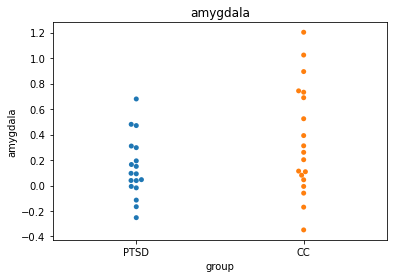

In [17]:
# Plot barplot to see differences
plt.title("amygdala")
#sns.barplot(x="group", y="amygdala", data=dfAll, ci=68)
sns.swarmplot(x="group", y="amygdala", data=dfAll)#, ci=68)

In [18]:
# run simple one-tailed t-test
t = scipy.stats.ttest_ind(dfAll['amygdala'][dfAll['group']=='CC'],dfAll['amygdala'][dfAll['group']=='PTSD'], 
                     equal_var = True)

# one tailed
t[1] /2

0.03410260419452769

## Use STAN to check differences

In [19]:
#To select rows whose column value is in list 
groups = ["CC", "PTSD"]
dg = dfAll[dfAll.group.isin(groups)]

# changing group to numbers before we run stan model
group = {'CC': 0,'PTSD': 1} 
dg.group = [group[item] for item in dg.group] 
dg.head()

,group,subject,amygdala,amgsem,amgstd
0,1,040,0.470255,0.022986,0.701370
1,1,029,0.480097,0.027650,0.843667
2,0,020,0.260270,0.022249,0.678866
3,0,1072,0.893891,0.022684,0.692152
4,1,1074,0.045975,0.026153,0.797999


In [20]:
# how many in each group
dg.groupby(['group']).count()

,subject,amygdala,amgsem,amgstd
group,,,,
0,19,19,19,19
1,18,18,18,18


In [21]:
data =  {'N': len(dg), 'x': dg['group'].values, 'y': dg['amygdala'].values}
sm = cmdstanpy.CmdStanModel(stan_file='Stan_model/simple_model.stan')


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/or/SIA_PTSD/Stan_model/simple_model


In [22]:
# Train the model and generate samples
seed = 1332 # set random seed
fit_simple_model = sm.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seed
  #inits = 0.2,
)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


In [23]:
#fit
fit_simple_model.summary(percentiles=(4.5,95.5))

,Mean,MCSE,StdDev,4.5%,95.5%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
lp__,19.00,0.03200,1.200,16.00,20.000,1600.0,18000.0,1.0
alpha,0.35,0.00190,0.082,0.21,0.490,1800.0,20000.0,1.0
beta,-0.21,0.00270,0.120,-0.41,-0.024,1800.0,21000.0,1.0
sigma,0.36,0.00089,0.044,0.29,0.440,2500.0,28000.0,1.0


In [24]:
# # Extracting traces
alpha = fit_simple_model.stan_variable(name='alpha')
beta = fit_simple_model.stan_variable(name='beta')
sigma = fit_simple_model.stan_variable(name='sigma')
#lp = fit_simple_model.stan_variable(name='lp')

In [25]:

np.percentile(beta, [0.055, 0.955])

array([-0.60715269, -0.48566069])

0.03374999999999995

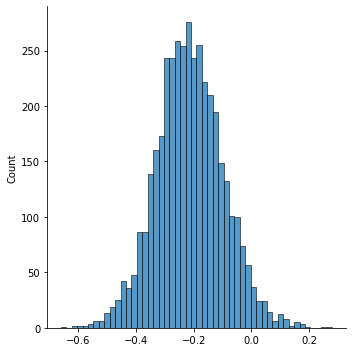

In [26]:
sns.displot(beta)
1 - sum(beta<0) / len(beta)

# Check correlation between amg and behavior

In [27]:
dfPCL = pd.read_csv('pclScores.csv')
# remove the RCF from beginning of subject id
dfPCL['subject'] = dfPCL['subject'].astype(str)
# because some subjects has two digits, we add zero
for i in dfPCL.iterrows():
    if len(i[1].subject) < 4:
        dfPCL.at[i[0],'subject'] = '0' + i[1].subject

dfPCL.head()

,group,subject,pcl_An,pcl_Av,pcl_total
0,PTSD,035,7.0,6.0,43.0
1,CC,011,0.0,0.0,0.0
2,PTSD,040,5.0,4.0,24.0
3,PTSD,029,0.0,1.0,11.0
4,CC,020,0.0,0.0,0.0


In [28]:
## Add BDI as well
dfBDI = pd.read_csv('behavioural/ReconsolidationOfFea_DATA_2021-10-26_1335.csv')
dfBDI.head()

,subject_id,redcap_event_name,bdi_1_sadness,bdi_2_pessimism,bdi_3_pastfailure,bdi_4_pleasure,bdi_5_guilt,bdi_6_punishment,bdi_7_selfdislike,bdi_8_selfcriticalness,...,bdi_13_indecisiveness,bdi_14_worthlessness,bdi_15_lossenergy,bdi_16_sleep,bdi_17_irritability,bdi_18_appetite,bdi_19_concentration,bdi_20_fatigue,bdi_21_sex,bdiii_complete
0,RCF020,self_reports_arm_1,0,0,0,0,0,0.0,0,0,...,0,0,1,2.0,0,0.0,1,1,1,2
1,RCF029,self_reports_arm_1,0,0,0,0,0,0.0,0,0,...,0,0,0,0.0,0,0.0,0,0,0,2
2,RCF040,self_reports_arm_1,1,2,2,2,2,2.0,2,2,...,1,2,1,1.0,2,0.0,2,1,1,2
3,RCF1072,self_reports_arm_1,0,1,0,1,0,0.0,1,0,...,0,0,1,2.0,0,1.0,0,1,0,2
4,RCF1074,self_reports_arm_1,2,2,0,2,2,0.0,1,1,...,1,1,1,4.0,1,2.0,2,2,1,2


In [29]:

sumBDI = np.sum(dfBDI.iloc[:,2:23], axis=1) # sum BDI scores
sumBDI
dfBDI['sum_bdi'] = sumBDI
dfBDI = dfBDI[['subject_id', 'sum_bdi']]

for i in dfBDI.iterrows():
    #print(i[1].subject_id)
    sub = i[1].subject_id.split('RCF')[1]
  #  print(sub)
    dfBDI.at[i[0], 'subject_id'] = sub
  
dfBDI.head()

,subject_id,sum_bdi
0,020,6.0
1,029,1.0
2,040,31.0
3,1072,8.0
4,1074,29.0


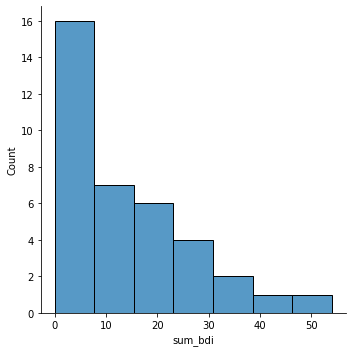

In [30]:
sns.displot(dfBDI.sum_bdi)

In [31]:
groups = ["CC", "PTSD"]
dfpcl_amg = pd.merge(dfPCL, amg_ud)
dfpcl_amg = dfpcl_amg[dfpcl_amg.group.isin(groups)]
dfpcl_amg.head()

,group,subject,pcl_An,pcl_Av,pcl_total,amygdala,amgsem,amgstd
0,PTSD,040,5.0,4.0,24.0,0.470255,0.022986,0.701370
1,PTSD,029,0.0,1.0,11.0,0.480097,0.027650,0.843667
2,CC,020,0.0,0.0,0.0,0.260270,0.022249,0.678866
3,CC,1072,1.0,0.0,14.0,0.893891,0.022684,0.692152
4,PTSD,1074,9.0,6.0,54.0,0.045975,0.026153,0.797999


In [32]:
# add sum bdi
dfpcl_amg_bdi = pd.merge(dfpcl_amg, dfBDI, left_on='subject', right_on='subject_id')
dfpcl_amg_bdi.head()

,group,subject,pcl_An,pcl_Av,pcl_total,amygdala,amgsem,amgstd,subject_id,sum_bdi
0,PTSD,040,5.0,4.0,24.0,0.470255,0.022986,0.701370,040,31.0
1,PTSD,029,0.0,1.0,11.0,0.480097,0.027650,0.843667,029,1.0
2,CC,020,0.0,0.0,0.0,0.260270,0.022249,0.678866,020,6.0
3,CC,1072,1.0,0.0,14.0,0.893891,0.022684,0.692152,1072,8.0
4,PTSD,1074,9.0,6.0,54.0,0.045975,0.026153,0.797999,1074,29.0


## Use function to get both R and CI
 - consider using pyStan for that also

In [33]:
def pearsonr_ci(x,y,alpha=0.05):
    from scipy import stats
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [34]:
## Correlation to two groups
pearsonr_ci(dfpcl_amg['pcl_An'], dfpcl_amg['amygdala'])

(-0.3460175565726868,
 0.035923463367463646,
 -0.6024878629985344,
 -0.024776401747961616)

In [35]:
pearsonr_ci(dfpcl_amg_bdi['sum_bdi'],dfpcl_amg_bdi['amygdala'])

(-0.23057321907877817,
 0.16976286971784918,
 -0.5160388930174389,
 0.10099080672853178)

In [36]:
## correlation only for PTSD group
dfpcl_ptsd = dfpcl_amg[dfpcl_amg.group=='PTSD']
print (pearsonr_ci(dfpcl_ptsd['pcl_An'], dfpcl_ptsd['amygdala']))

# BDI
dfpcl_ptsd_bdi = dfpcl_amg_bdi[dfpcl_amg_bdi.group=='PTSD']
print (pearsonr_ci(dfpcl_ptsd_bdi['sum_bdi'], dfpcl_ptsd_bdi['amygdala']))

(-0.5887201179619634, 0.01015787722963919, -0.8280075186663997, -0.16803560604350543)
(-0.3921306670268322, 0.10751452054542127, -0.7260751968116282, 0.09148859669932687)


In [37]:
## correlation only for Combat Controls group
dfpcl_cc = dfpcl_amg[dfpcl_amg.group=='CC']
pearsonr_ci(dfpcl_cc['pcl_An'], dfpcl_cc['amygdala'])

(0.09380073675917955,
 0.7024953008277913,
 -0.376447142526664,
 0.5256160636669169)

In [38]:
sns.color_palette()[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

## generate publication plots

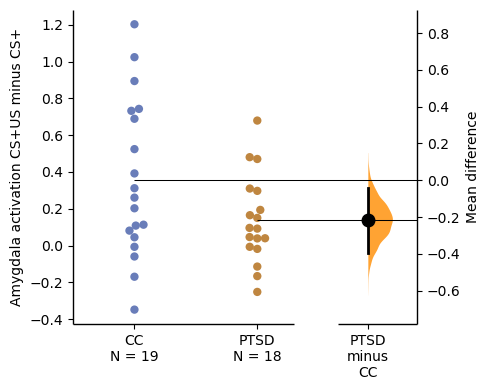

In [39]:
import dabest
groups = ["CC", "PTSD"]
dgr = dfAll[dfAll.group.isin(groups)]

# load our data to dabest to produce graphs
dgr = dgr.rename(columns={"amygdala": "Amygdala activation CS+US minus CS+", "group": "Group"})
dgr_dabest = dabest.load(data=dgr, x='Group', y='Amygdala activation CS+US minus CS+', 
                                  idx=('CC','PTSD'), ci=89)
g1 = dgr_dabest.mean_diff.plot(custom_palette={'CC':'royalblue','PTSD':'darkorange'})
g1.savefig('cleanData_RCF.png', dpi=300, bbox_inches="tight")

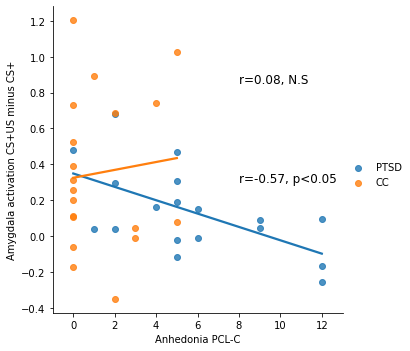

In [40]:
fgrid = sns.lmplot(x='pcl_An', y='amygdala',hue='group', data=dfpcl_amg, ci = None)
               #legend_out = True)
# need to add annotation- because its like facet grid we need to set each axis
ax1 = fgrid.axes[0,0]
    #Remove legend title
ax1.set_xlim(-1,13)
#Set labels of x and y axis
fgrid.set(xlabel='Anhedonia PCL-C', ylabel='Amygdala activation CS+US minus CS+')
ax1.text(8, .3, "r=-0.57, p<0.05", horizontalalignment='left', size='large', color='black')#, weight='semibold')
ax1.text(8, .85, "r=0.08, N.S", horizontalalignment='left', size='large', color='black')#, weight='semibold')

fgrid._legend.set_title('')
#ax.annotate("An annotation")#, horizontalalignment='left', size='medium', color='black', weight='semibold')


Text(6, 0.3, 'r=-0.37, p<0.05')

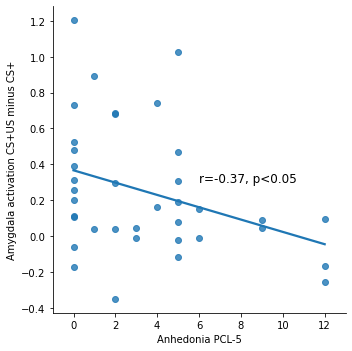

In [41]:
# Graph both groups
fgrid = sns.lmplot(x='pcl_An', y='amygdala', data=dfpcl_amg, ci = None)
               #legend_out = True)
# need to add annotation- because its like facet grid we need to set each axis
ax1 = fgrid.axes[0,0]
    #Remove legend title
ax1.set_xlim(-1,13)
#Set labels of x and y axis
fgrid.set(xlabel='Anhedonia PCL-5', ylabel='Amygdala activation CS+US minus CS+')
ax1.text(6, .3, "r=-0.37, p<0.05", horizontalalignment='left', size='large', color='black')#, weight='semibold')


#fgrid._legend.set_title('')

In [42]:
rub = scipy.stats.theilslopes(y=dfpcl_amg.pcl_An.values, x=dfpcl_amg.amygdala.values, alpha=0.9)
rub

(-2.2143454110745373, 2.3323056536938007, -5.600623875495698, 0.0)

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'Emotional Numbing PCL-5'),
 Text(0.5, 0, 'Amygdala activation CS+US minus CS+')]

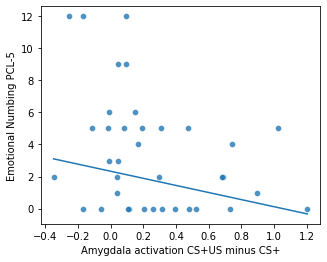

In [43]:
# plot a line based on the robust regression
plt.figure(figsize=(5,4))
line = rub[1] + rub[0]*dfpcl_amg.amygdala
fgrid = sns.scatterplot(y='pcl_An', x='amygdala',data=dfpcl_amg, alpha=0.8)
#plt.plot(dfpcl_amg.amygdala, line)#,alpha = 0.8)
sns.lineplot(dfpcl_amg.amygdala, line)
fgrid.set(ylabel='Emotional Numbing PCL-5', xlabel='Amygdala activation CS+US minus CS+')

## Robust regression using Stan

In [44]:
data =  {'N': len(dfpcl_amg), 'x': dfpcl_amg['amygdala'].values, 'y': dfpcl_amg['pcl_An'].values}
sm_robust = cmdstanpy.CmdStanModel(stan_file='Stan_model/robust_reg.stan')


In [45]:
seedRubost = 156 # seed
fit_robust_reg = sm_robust.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  seed = seedRubost
  #inits = 0.2,
)

In [46]:
fit_robust_reg.summary(percentiles=(4.5,95.5))

,Mean,MCSE,StdDev,4.5%,95.5%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
lp__,-76.0,0.040,1.40,-79.0,-75.00,1300.0,8700.0,1.0
alpha,4.1,0.017,0.74,2.8,5.20,1900.0,13000.0,1.0
beta,-3.1,0.037,1.60,-6.0,-0.51,1900.0,13000.0,1.0
sigma,3.4,0.010,0.46,2.7,4.20,1900.0,13000.0,1.0
nu,22.0,0.410,13.00,5.7,47.00,990.0,6500.0,1.0


In [47]:
alpha = fit_robust_reg.stan_variable(name='alpha')
beta = fit_robust_reg.stan_variable(name='beta')

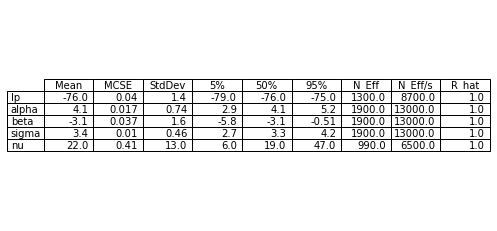

In [48]:
## Create a table
df_fit = fit_robust_reg.summary()
plt.rcParams["figure.figsize"] = [8, 4]
fig, ax =plt.subplots(1,1)
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df_fit.values,colLabels=df_fit.columns,
         rowLabels=["lp_","alpha","beta", "sigma", "nu"],loc="center")
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


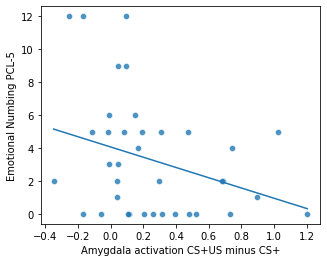

In [49]:
# plot a line based on the robust regression
plt.figure(figsize=(5,4))
line = np.mean(alpha) + np.mean(beta)*dfpcl_amg.amygdala
fgrid = sns.scatterplot(y='pcl_An', x='amygdala',data=dfpcl_amg, alpha=0.8)
#plt.plot(dfpcl_amg.amygdala, line)#,alpha = 0.8)
sns.lineplot(dfpcl_amg.amygdala, line)
fgrid.set(ylabel='Emotional Numbing PCL-5', xlabel='Amygdala activation CS+US minus CS+')
plt.savefig('RCF_robustRegression.png', dpi=300, bbox_inches="tight")